### Lotka-Volterra Predator-Prey Differential Equation Parameter Optimization with Gradient Descent  

The Lotka-Volterra predator-prey equations are a system of differential equations modeling the relationship of a predator and prey species' populations at any given time, without the interference of other variables. At a base level, when prey population rises the predator population has more food thus also rises. With more predators, prey population falls and the predators have less to eat and begin to die off. The cycle continues. The Hudson Bay Company's data on Snowshoe Hare and Canadian Lynx pelts from 1845-1937 is a great dataset to model this system due to the lynx being the hare's only predator and the hare being the lynx's only prey in that ecosystem. Their relationship is modeled by these equations: 

                           dH/dt = aH - bHL                  dL/dt = -cL + dHL
                           
where H and L are the hare and lynx populations at any given time, dH/dt and dL/dt are the rates of change in population, "a" and "c" are hare/lynx growth parameters, and "b"/"d" are predator-prey interaction parameters (i.e. how well the hare survives being hunted by the lynx and vice versa). Note "c" is negative because the lynx dies off without interaction with the hare species. Similarly, the "b" term is negative due to the interaction negatively impacting the hare population. Each of "a", "b", "c", and "d" are changeable parameters that can be modified to optimize models based on context.

Finding solutions to the system of differential equations can give us a model of how the two populations change and interact over time. We can do this by finding numerical approximations using the Fourth Order Runge-Kutta numerical method for systems of equations, and optimize the parameters using gradient descent.

In [625]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

df = pd.read_csv(r'C:/Users/Matthew/Documents/lynxhare.csv')

Below is the Fourth Order Runge-Kutta method modified to function for a system of DEs. This particular system is good example as to why it's important to be able to code your own methods from scratch: if you take another look at the above equations you may notice neither of them are dependent on time. Built in methods such as scipy.integrate.ode require time as a parameter, and wouldn't function in this instance. Hence this version of Runge-Kutta has also been modified to disregard time (we only need to know how many steps to approximate, not the specific instance of time).

In [626]:
def rungKutSys(a,b,h,init,f,o): # a, b = start, stop; h=step-size; init=initial conditions, f=list of DEs to be solved;
    m = len(f)                  # o is list of parameters a, b, c, d interpreted as theta0, theta1, theta2, theta3
    n = int((b-a)/h)
    w = init
    wi = np.zeros((n+1,m))
    wi[0][0] = w[0]
    wi[0][1] = w[1]
    
    for i in range(1,n+1):
        k = np.zeros((4,m))
        for j in range(m):
            k[0][j] = h*f[j](w[0],w[1],o)
        for j in range(m):
            k[1][j] = h*f[j](w[0] + k[0][0]/2, w[1] + k[0][1]/2,o)
        for j in range(m):
            k[2][j] = h*f[j](w[0] + k[1][0]/2, w[1] + k[1][1]/2,o)
        for j in range(m):
            k[3][j] = h*f[j](w[0] + k[2][0], w[1] + k[2][1],o)
        for j in range(m):
            w[j] += (k[0][j] + 2*k[1][j] + 2*k[2][j] + k[3][j])/6
            wi[i][j] = w[j]

        hare, lynx, hare_aes, lynx_aes = [], [], [], []
        for i in range(0,len(wi)):
            hare_aes.append(wi[i][0])
            lynx_aes.append(wi[i][1])
        for i in range(0,len(wi),int(1/h)):
            hare.append(wi[i][0])
            lynx.append(wi[i][1])
            
    return hare, lynx, hare_aes, lynx_aes  # function returns list of approximated values for hare and lynx populations

Here are the predator-prey equations translated to Python:

In [627]:
def f1(x_,y_,o):
    o0, o1 = o[0], o[1]
    return (o0*x_ - o1*x_*y_)
    
def f2(x_,y_,o):
    o2, o3 = o[2], o[3]
    return (-o2*y_ + o3*x_*y_)

For the purposes of this model, I'm only going to test against data from 1903-1937 as it's much less volatile. In addition, I'll of course use the 1903 populations for my initial conditions.

In [628]:
x, y = df['Hare'], df['Lynx']
x, y = [], []
for i in range(29,len(df['Hare'])):
    x.append(df['Hare'][i]) 
    y.append(df['Lynx'][i])
init = [x[0],y[0]]

We now need to pick some initial parameters. I wasn't exactly sure where to start, but with a bit of research I was able to find some approximations based on Malthusian growth models****. Utilizing the fact that equilibrium occurs when dH/dt=0 and dL/dt=0 and some math we can show the equilibrium (He, Le) occurs at (theta2/theta3, theta0/theta1). Averaging data two maximums or minimums may be decent approximations for equilibrium.

**** http://jmahaffy.sdsu.edu/courses/f09/math636/lectures/lotka/qualde2.html 
© 2000, All Rights Reserved, SDSU & Joseph M. Mahaffy, San Diego State University

In [629]:
print('Hare Data:',x)
print('Lynx Data:',y)

Hare Data: [65, 45, 30, 25, 27, 77, 25, 10, 10, 46, 80, 20, 8, 6, 6, 20, 83, 12]
Lynx Data: [25, 62, 49, 7, 7, 20, 43, 11, 6, 20, 37, 43, 50, 30, 15, 18, 40, 48]


I'll choose data between 80 and 83 for hare and data between 62 and 43 for lynx.

In [630]:
He, Le = np.mean(x[10:17]), np.mean(y[1:7])
He, Le = np.mean(x[10:17]), np.mean(y[1:7])
print('Hare equilibruim:',He)
print('Lynx equilibruim:',Le)

Hare equilibruim: 31.8571428571
Lynx equilibruim: 31.3333333333


According to Malthusian growth models, we should be able to approximate theta0 and theta2 by solving for theta0 in  
H1=H0(e^theta0), where H1 is the population directly succeeding H0 during a time of rapid growth. Similarly we need to solve for theta2 in L1=L0(e^(-theta2)), where L1 is the population directly succeeding L0 in a time of rapid decay.

I'll choose H0=6, H1=20, L0=43, and L1=11.

In [631]:
o = [0,0,0,0]
o[0] = np.log(20/6)
o[2] = np.log(43/11)
print(o)

[1.2039728043259361, 0, 1.3633048428951919, 0]


To solve for theta1 and theta3 we just need to use the equilibrium equations previously shown.

In [632]:
o[1] = o[0]/Le
o[3] = o[2]/He
print(o)

[1.2039728043259361, 0.038424663967849028, 1.3633048428951919, 0.042794322422719029]


Now we have all the data necessary to approximate the initial model with the starting parameters.

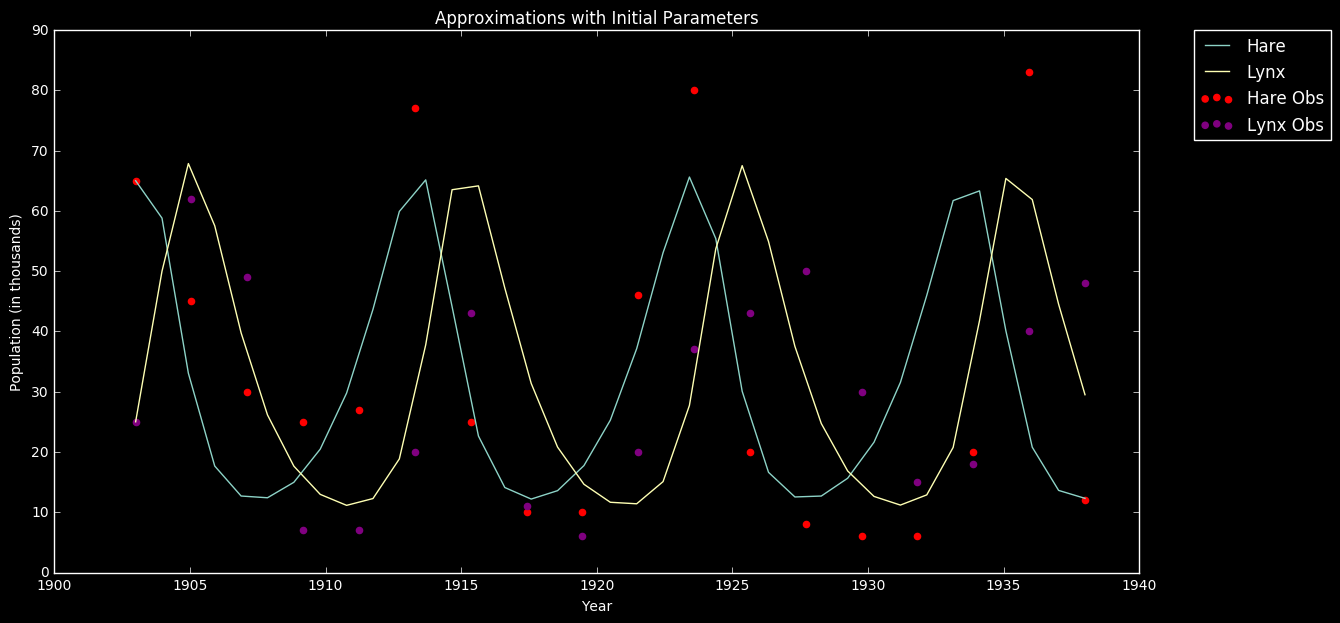

In [633]:
hare_, lynx_, hare_aes, lynx_aes = rungKutSys(0,len(x),.5,init,[f1,f2],o)
t = np.linspace(1903,1938,num=len(hare_aes)) #Hudson Bay Company's data skips every other year
fig, ax = plt.subplots(figsize=(14, 7))
plt.plot(t,hare_aes,label="Hare")
plt.plot(t,lynx_aes,label="Lynx")
t = np.linspace(1903,1938,num=len(x))
plt.scatter(t,x,color="red",label="Hare Obs")
plt.scatter(t,y,color="purple",label = "Lynx Obs")
plt.xlabel('Year')
plt.ylabel('Population (in thousands)')
plt.title('Approximations with Initial Parameters')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Not horrible, but looks like it could be improved. This is where gradient descent comes into the mix. In case you aren't aware of how gradient descent works, I'll give a brief explanation. Gradient descent is an algorithm used to minimize an arbitrary function. In many cases, like this one, gradient descent can be used to optimize parameters by iterating over model creation and calculating minimizing an error function (commonly called the "cost function" in gradient descent). A learning rate is chosen to see how the error will change with a small change in the parameters. A partial derivative is calculated for each parameter, and the parameter is altered accordingly. Essentially, this will find the "steepest" drop in error at each step and will complete when the error reaches a local minima. Our optimization problem is unique in that we're technically optimizing two functions, the hare and lynx curves. My idea for a work around is to think of each time step as its own point, (hare_population, lynx_population). At any given time, the error will be the distance from the actual (hare, lynx) point to the Runge-Kutta (hare, lynx) approximated point. The overall cost function is the average distance over every time step.

In [634]:
def cost_f(x,y,o):
    hare_, lynx_, hare_aes, lynx_aes = rungKutSys(0,len(x),.5,[x[0],y[0]],[f1,f2],o)
    hare_.pop()
    lynx_.pop()
    a = np.array([hare_,lynx_])
    b = np.array([x,y])
    J = (1/len(x)) * np.sum(np.sqrt((b[0]-a[0])**2 + (b[1]-a[1])**2))
    
    return J

Let's start with finding the error with the initial parameter.

In [635]:
print('Initial cost:',cost_f(x,y,o))

Initial cost: 18.9048684354


Now let's see how much gradient descent can decrease that error.

In [636]:
def gradient_descent(x,y,a,h,o,cost_f,tol): # x, y = observed data; a = learning rate; h = arbitrary number close to 0; 
    J = cost_f(x,y,o)                       # o = parameters to be optimized; cost_f = cost function; tol = error tolerance
    err = 1
    i = 1
    j_list = [J]
    while abs(err) > tol:
                   # approximations of partial derivatives (our cost function isn't differentiable)
        der_o0 = (cost_f(x,y,[o[0]+h,o[1],o[2],o[3]]) - cost_f(x,y,[o[0],o[1],o[2],o[3]])) * (1/h)
        der_o1 = (cost_f(x,y,[o[0],o[1]+h,o[2],o[3]]) - cost_f(x,y,[o[0],o[1],o[2],o[3]])) * (1/h)
        der_o2 = (cost_f(x,y,[o[0],o[1],o[2]+h,o[3]]) - cost_f(x,y,[o[0],o[1],o[2],o[3]])) * (1/h)
        der_o3 = (cost_f(x,y,[o[0],o[1],o[2],o[3]+h]) - cost_f(x,y,[o[0],o[1],o[2],o[3]])) * (1/h)
                   # altering parameters
        temp_o0 = o[0] - a*der_o0
        temp_o1 = o[1] - a*der_o1
        temp_o2 = o[2] - a*der_o2
        temp_o3 = o[1] - a*der_o3
        
        o[0] = temp_o0
        o[1] = temp_o1
        o[2] = temp_o2
        o[3] = temp_o3
        
        J1 = cost_f(x,y,o)
        err = J1 - J
        J = J1
        j_list.append(J)
        i += 1
        if i > 9000:
            print('max iterations reached; no convergence')
            return o, J, j_list
    return o, J, j_list

In [637]:
theta, J, j_list  = gradient_descent(x, y, 1e-6, 1e-8, o, cost_f, 1e-4)

reduced cost: 17.6220697399
new parameters: [1.2040401290313911, 0.04497543246509781, 1.3634511652307733, 0.044742220238323284]


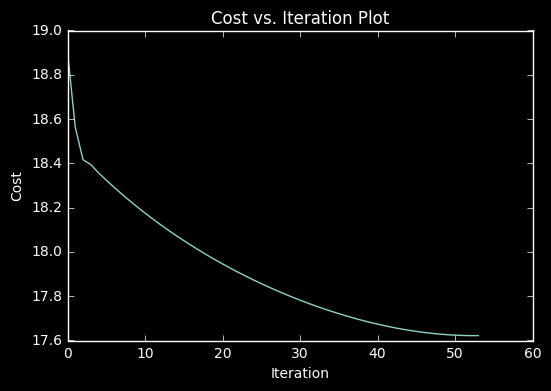

In [638]:
print('reduced cost:',J)
print('new parameters:',theta)
plt.plot(j_list)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost vs. Iteration Plot')
plt.show()

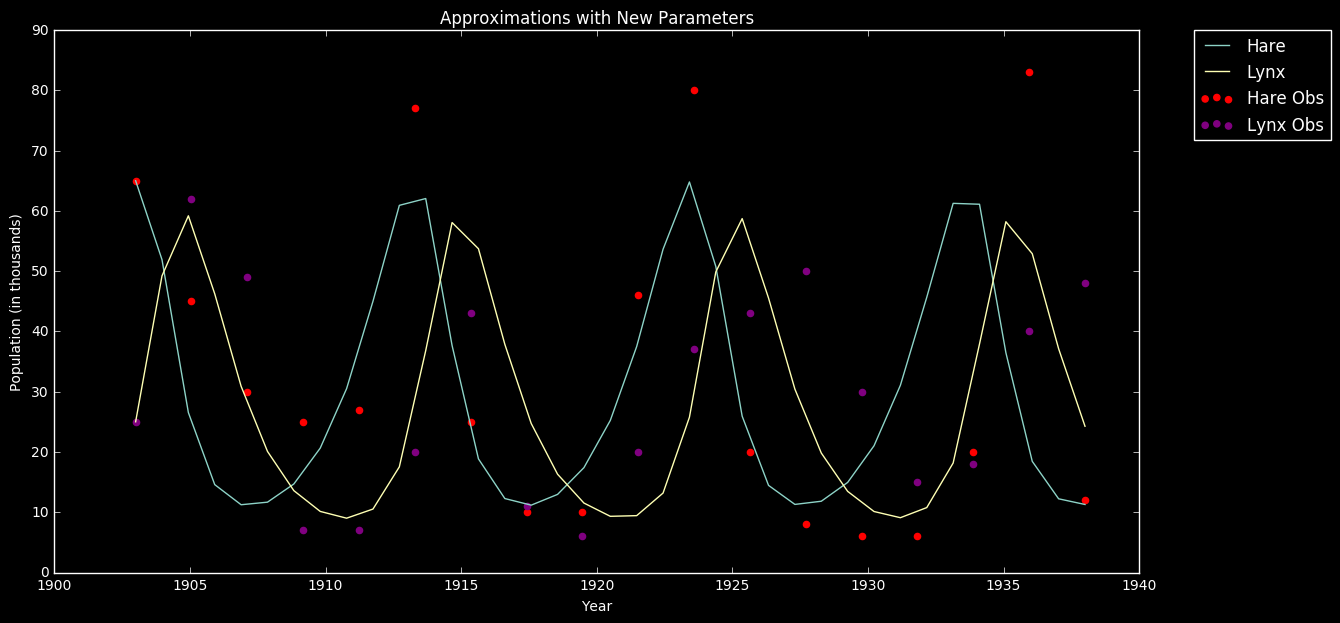

In [639]:
hare_, lynx_, hare_aes, lynx_aes = rungKutSys(0,len(x),.5,[x[0],y[0]],[f1,f2],theta)
t = np.linspace(1903,1938,num=len(hare_aes)) #Hudson Bay Company's data skips every other year
fig, ax = plt.subplots(figsize=(14, 7))
plt.plot(t,hare_aes,label="Hare")
plt.plot(t,lynx_aes,label="Lynx")
t = np.linspace(1903,1938,num=len(x))
plt.scatter(t,x,color="red",label="Hare Obs")
plt.scatter(t,y,color="purple",label = "Lynx Obs")
plt.xlabel('Year')
plt.ylabel('Population (in thousands)')
plt.title('Approximations with New Parameters')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Gradient descent reduced average distance from the model to the actual population by about 1 unit. It's not much, but it probably means our initial guess for parameters was pretty accurate. Below is an example where the initial parameters were shifted very slightly, still coming near the same result.

Initial cost: 26.2698308625
Altered initial parameters: [1.2, 0.03, 1.6, 0.05]


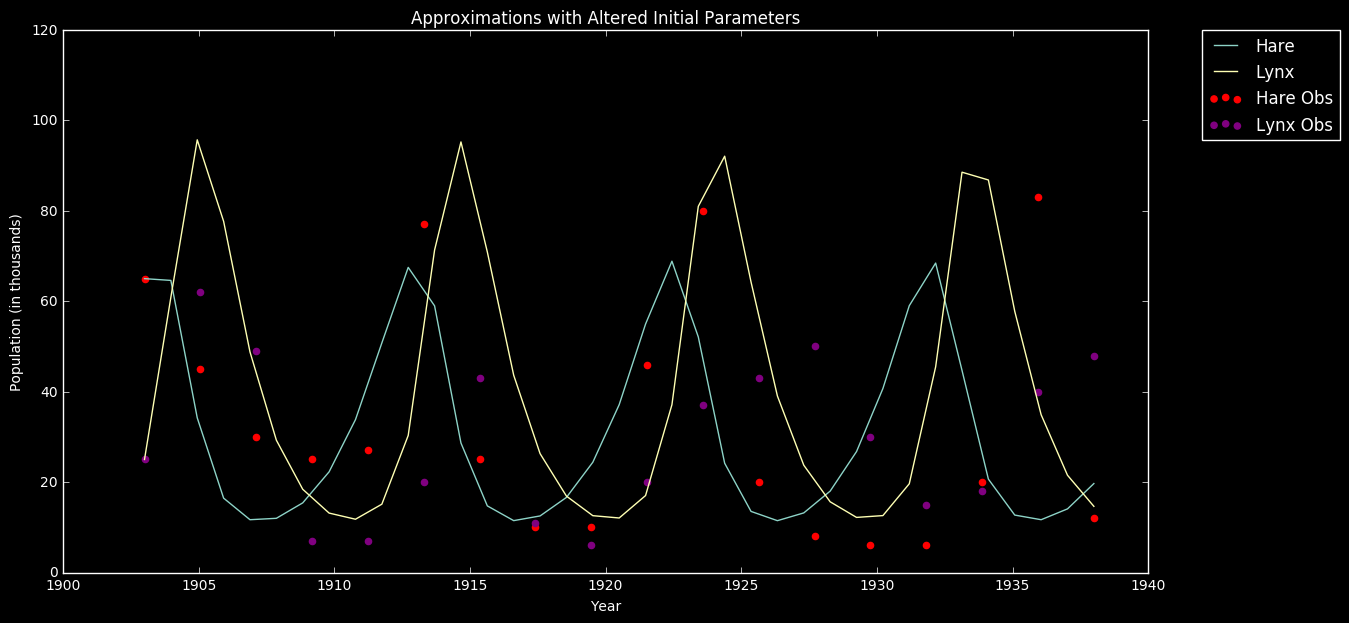

In [640]:
o = [1.2, .03, 1.6, .05]
print('Initial cost:',cost_f(x,y,o))
print('Altered initial parameters:',o)
hare_, lynx_, hare_aes, lynx_aes = rungKutSys(0,len(x),.5,[x[0],y[0]],[f1,f2],o)
t = np.linspace(1903,1938,num=len(hare_aes)) #Hudson Bay Company's data skips every other year
fig, ax = plt.subplots(figsize=(14, 7))
plt.plot(t,hare_aes,label="Hare")
plt.plot(t,lynx_aes,label="Lynx")
t = np.linspace(1903,1938,num=len(x))
plt.scatter(t,x,color="red",label="Hare Obs")
plt.scatter(t,y,color="purple",label = "Lynx Obs")
plt.xlabel('Year')
plt.ylabel('Population (in thousands)')
plt.title('Approximations with Altered Initial Parameters')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

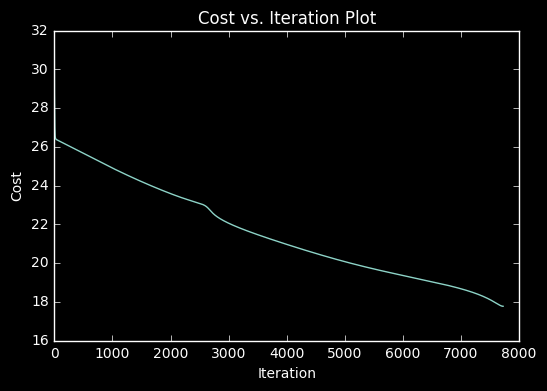

In [641]:
theta, J, j_list = gradient_descent(x, y, 1e-6, 1e-8, o, cost_f, 1e-4)
plt.plot(j_list)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost vs. Iteration Plot')
plt.show()

New cost: 17.7658821249
New parameters [1.121534856413885, 0.045034115925516288, 1.437539219994298, 0.044961056884743583]


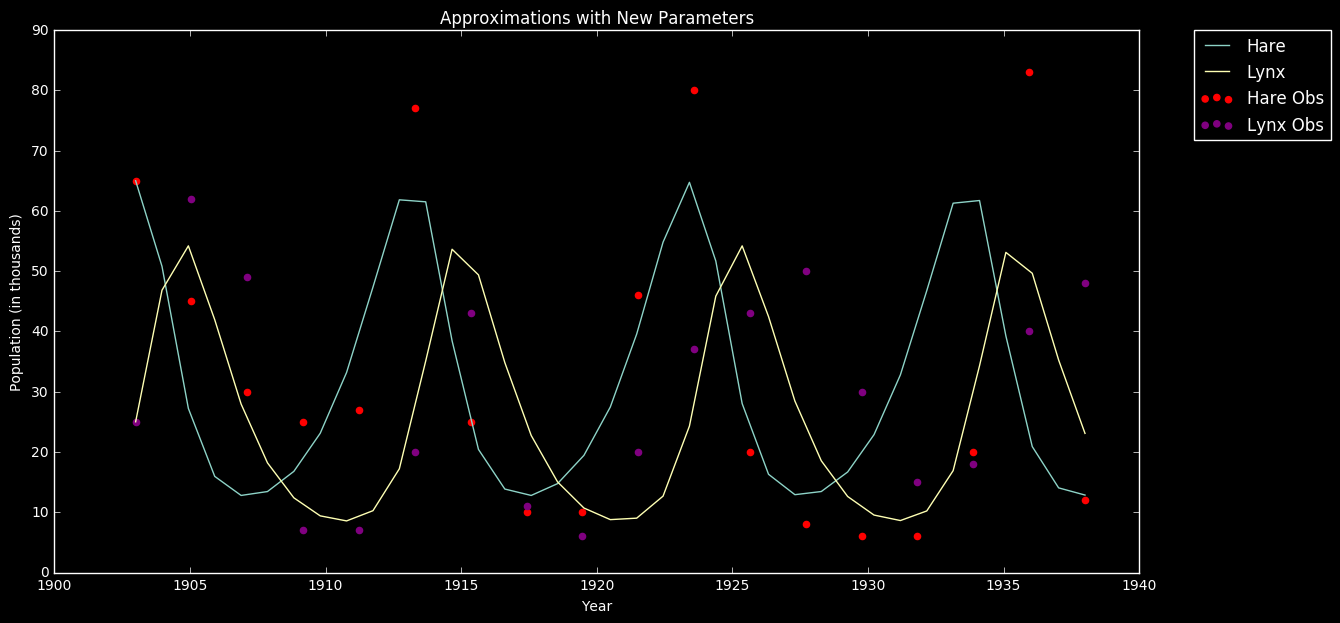

In [642]:
print('New cost:',J)
print('New parameters',theta)
hare_, lynx_, hare_aes, lynx_aes = rungKutSys(0,len(x),.5,[x[0],y[0]],[f1,f2],theta)
t = np.linspace(1903,1938,num=len(hare_aes)) #Hudson Bay Company's data skips every other year
fig, ax = plt.subplots(figsize=(14, 7))
plt.plot(t,hare_aes,label="Hare")
plt.plot(t,lynx_aes,label="Lynx")
t = np.linspace(1903,1938,num=len(x))
plt.scatter(t,x,color="red",label="Hare Obs")
plt.scatter(t,y,color="purple",label = "Lynx Obs")
plt.xlabel('Year')
plt.ylabel('Population (in thousands)')
plt.title('Approximations with New Parameters')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Here, gradient descent reduced average distance by about 9 units. The difference in graphs before and after this time especially shows the significance.

#### A Few Extra Notes on Stability and Learning Rate Choice

The last gradient descent performed just above took a noticeably large amount of iterations. The reason the algorithm needed so many iterations was because the learning rate used was very small (1e-6). Normally, the solution would be to increase the learning rate, but in this case we cannot. This system of differential equations is highly unstable, meaning small perturbations in the data will have large effects on the outcome. Thus, the larger the learning rate, the more likely gradient descent will overshoot a minimum and diverge. Below is an example of this occuring with the same initial values of theta used above, but with the learning rate set to 1e-5 instead of 1e-6. 

max iterations reached; no convergence


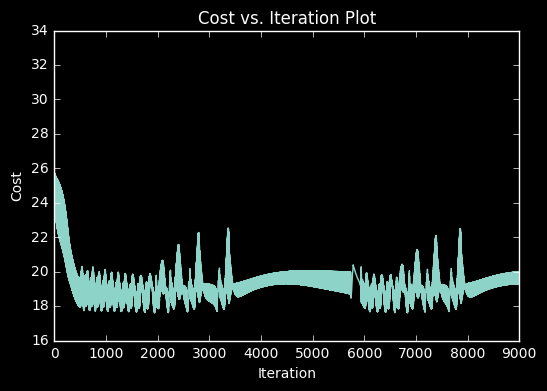

In [643]:
o = [1.2, .03, 1.6, .05]
theta, J, j_list = gradient_descent(x, y, 1e-5, 1e-8, o, cost_f, 1e-4)
plt.plot(j_list)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost vs. Iteration Plot')
plt.show()

Taking a look at the iterations, you can see the cost oscillate back and forth. The algorithm failed to converge because the learning rate caused it to hop over the minimum.

### Conclusions

Could we have found a better model for the hare/lynx relationship? Certainly, although for its simplicity it does do a decent job. The main function of this exercise was to illustrate the versatility of gradient descent and how it can be used in conjunction with other numerical algorithms. It also shows a weakness in gradient descent depending on the model. In our case, if these differential equations were being used to process live data, this model would not be feasible because of the sheer inconsistency of convergence.